* * *
<pre> NYU Paris            <i> Machine Learning - Spring 2023 </i></pre>
* * *


<h1 align="center"> Lab 5: the multilayer perceptron </h1>

<pre align="left"> February 22th 2023               <i> Author: Guillaume Staerman </i></pre>
* * *


##### Goal:
- Implement your Multilayer perceptron model

## Installing and importing Pytorch

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor


# Versions of torch and torchvision have to be compatible.
# check here: https://github.com/pytorch/pytorch/wiki/PyTorch-Versions

### Loading and preparing the MNIST dataset

In [2]:
# Define training and testing data using the functions in the cell above. 

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## Question 1

### Visualize some elements of the dataset:

torch.Size([60000, 28, 28])
torch.Size([1, 28, 28])


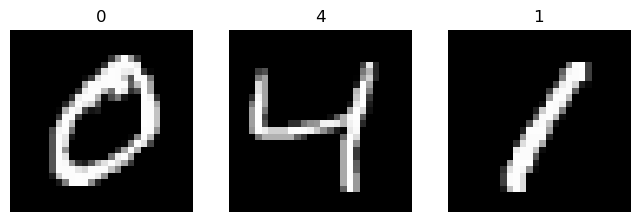

In [3]:
import matplotlib.pyplot as plt
# Visualize some images of the MNIST dataset
# Size of training data
print(train_data.data.shape)
#print(dir(train_data))
# Size of testing data

labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 1
for i in range(1, cols * rows + 1):
    sample_idx = i
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
print(img.shape)
plt.show()

## Question 2

### Define a dataloader to construct a batch-wise iterator from your train/test data


In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 10
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## Question 3

### Design your own Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F
# number of features (len of X cols)
input_dim = 28 * 28

# number of hidden layers
hidden_dim = 256

# number of classes (unique of y)
output_dim = 10

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h_relu = nn.ReLU()
        
        flattened = x.view(-1, input_dim) #flatten data to match dimension
        
        hidden = self.linear1(flattened) #dimensional reduction
        
        activated = h_relu(hidden) #ignore negs
        
        y_pred = self.linear2(activated) #output scores
        
        return y_pred

## Question 4

### Train your neural network on the trainloader

In [6]:
%%time
from torch.nn.functional import nll_loss, cross_entropy, log_softmax
import torch.optim as optim

mlp = MLP()
print(mlp.parameters)

# Optimizer
epochs = 2 #how many times we are gonna iterate over the data set
learning_rate = 1e-6  #small for preventing overshooting, could be smaller 
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

# Choice of the loss
criterion = cross_entropy # can also be nll_loss



def training(optimizer, criterion, epochs, learning_rate):
    losses = []
    for t in range(epochs):
        for i, data in enumerate(trainloader):
            inputs, labels = data

            # set optimizer to zero grad to remove previous epoch gradients
            optimizer.zero_grad()

            # Evaluate the loss
            outputs = mlp.forward(inputs)

            if criterion == cross_entropy: 
                loss = criterion(outputs, labels) #cross_entropy incorporates softmax
            elif criterion == nll_loss:
                loss = F.nll_loss(F.log_softmax(outputs, dim=1), labels) #softmax gets the probability for the outputs

            # backward propagation
            loss.backward()

            # One optimization step (gradient descent)
            optimizer.step()

            losses.append(loss.item())

            if not i % 2000:
                print(t, i, loss.item())
    return losses


<bound method Module.parameters of MLP(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)>
CPU times: user 1.89 ms, sys: 1.73 ms, total: 3.62 ms
Wall time: 7.05 ms


In [7]:
losses = training(optimizer, criterion, epochs, learning_rate)

0 0 2.3298230171203613
0 2000 2.2057456970214844
0 4000 2.0921757221221924
1 0 2.1043758392333984
1 2000 1.9757614135742188
1 4000 1.7829921245574951


## Question 5

### Inspect the optimization procedure through the loss (plot the loss), what do you observe?

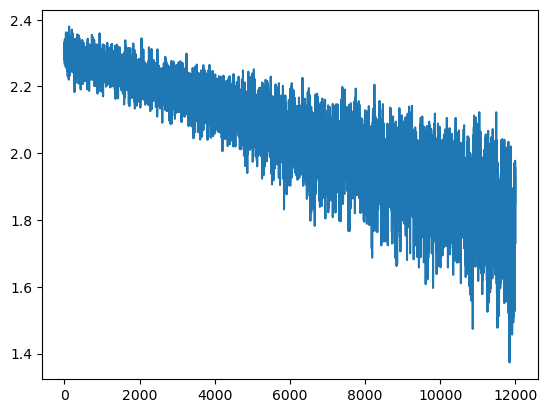

In [8]:
plt.plot(losses)

As expected, the loss decreases as the number of interations increases. However, the loss is very noisy because our batch size is small. We do not have a lot of information to figure out where to go to achieve our minimization. We might point to the incorrect direction several times before finally approximating the global minimum.

## Question 6

### Evaluate the quality of your classifier on the test set

In [9]:
size_test = test_data.data.shape[0]


def accuracy(mlp):
    correct = 0
    for data in testloader:
        inputs, labels = data
        outputs = mlp.forward(inputs)
        #loss = criterion(outputs, labels)
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum()

    return correct/size_test # To do

print(accuracy(mlp))

tensor(0.7500)


## Question 7 (Bonus)

### Repeat this training with different loss (nll/cross_entropy...) and different number of epochs. What do you observe?

In [10]:
mlp = MLP()
print(mlp.parameters)

# Optimizer
epochs = 10 
learning_rate = 1e-3 
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

# Choice of the loss
criterion = cross_entropy # nll_loss

training(optimizer, criterion, epochs, learning_rate)

accuracy(mlp)

<bound method Module.parameters of MLP(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)>
0 0 2.304267406463623
0 2000 0.29273074865341187
0 4000 0.034727875143289566
1 0 0.005455571226775646
1 2000 0.05193888396024704
1 4000 0.013632895424962044
2 0 0.0016173949697986245
2 2000 0.029883746057748795
2 4000 0.018077412620186806
3 0 0.00037838725256733596
3 2000 0.0023311858531087637
3 4000 0.0007897831383161247
4 0 9.226772817783058e-05
4 2000 0.01249297522008419
4 4000 0.0011889293091371655
5 0 1.331534167547943e-05
5 2000 0.0026938205119222403
5 4000 0.00035107159055769444
6 0 8.773485205892939e-06
6 2000 0.0001179767568828538
6 4000 0.00022259741672314703
7 0 2.074051371891983e-05
7 2000 0.004722735844552517
7 4000 0.006229464430361986
8 0 1.10623759610462e-05
8 2000 0.002364029176533222
8 4000 0.0009179603075608611
9 0 5.9126568885403685e-06
9 2000 8.96429264685139e-06
9 4000 0.0006198065239004791


tensor(0.9683)

Terrible parameters on purpose below!!

In [11]:
mlp = MLP()
print(mlp.parameters)

# Optimizer
epochs = 3 
learning_rate = 1 
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

# Choice of the loss
criterion = cross_entropy # nll_loss

training(optimizer, criterion, epochs, learning_rate)

accuracy(mlp)

<bound method Module.parameters of MLP(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)>
0 0 2.3258421421051025
0 2000 2.614046335220337
0 4000 2.614877223968506
1 0 87.41511535644531
1 2000 2.62685227394104
1 4000 2.614985466003418
2 0 655.9989624023438
2 2000 2.626758098602295
2 4000 2.6149916648864746


tensor(0.1010)

In [12]:
#using nll_loss

%%time
from torch.nn.functional import nll_loss, cross_entropy
import torch.optim as optim

mlp = MLP()
print(mlp.parameters)

# Optimizer
epochs = 2 #
learning_rate = 1e-6
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

# Choice of the loss
criterion = nll_loss

training(optimizer, criterion, epochs, learning_rate)

accuracy(mlp)

<bound method Module.parameters of MLP(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)>
0 0 2.304450511932373
0 2000 2.255970001220703
0 4000 2.145508050918579
1 0 2.0942842960357666
1 2000 2.0316388607025146
1 4000 1.8374134302139282
CPU times: user 1min 13s, sys: 1min 44s, total: 2min 58s
Wall time: 46.5 s


tensor(0.7607)

The general remark is that our model is complex enough to generate accurate predicitons (about 97%) provided the correct parameters. On the other hand, given a very large learning rate, our model performs very poorly. This is because when we "miss" the correct direction (which can happen because we are taking gradient for a batch sample, and not from the entire data set), we go very far away from our minimum. Another thing that can happen is that we overshoot the minimum even if we went in the right direction. 

nll_loss-based NN has a similar behavior to the cross-entropy one.

